## Creating train/test split with non-overlapping EEG windows (on data filtered for NaN) 

In this notebook, we filter the dataset based on the number of NaN values and overlapping EEG windows, and perform train test split stratified on expert consensus. Additionally, we make sure that the patient IDs in train and test sets are disjoint, and that the test set does not contain any row with fewer than 3 expert votes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train_with_nan_info.csv')

Filter out rows whose corresponding 50s eeg windows or 600s spectrograms have more than 1 missing values.

In [3]:
df = df[ (df['eeg_50sec_nan_row_count'] <= 1) & (df['eeg_10sec_nan_row_count'] <= 1) & (df['spectrogram_600sec_nan_row_count'] <= 1) & (df['spectrogram_10sec_nan_row_count'] <= 1)  ]

## Select rows with non-overlapping 10s eeg windows.

We do this to avoid over representing data points with multiple time offsets close to one another. To achieve this, we first bin the offset seconds into 10s bins, and then select the first row in every other bin, thus ensuring the offset seconds are at least 10s apart.

In [4]:
df['offset_bins'] = pd.cut(df['eeg_label_offset_seconds'], bins=[i*10 - 1 for i in range(339)])
df['offset_bins'] = df['offset_bins'].astype('str')
df['offset_bins'] = df['offset_bins'].apply(lambda x : (int(x.split(',')[1][1:-1]) + 1) // 10 - 1 )

In [5]:
df = df.loc[df['offset_bins'] % 2 == 0]
df.shape[0]

60940

In [6]:
df = df.groupby(['eeg_id', 'offset_bins']).agg('first').reset_index()
df.shape[0]

31239

## Calculate the total number of expert votes, and normalize votes to percentages.

In [7]:
vote_cols = [c for c in df.columns if '_vote' in c]
vote_cols

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [8]:

df['total_votes'] = df[vote_cols].sum(axis=1)

In [9]:
for c in vote_cols:
    df[c] = df[c] / df['total_votes']


We will now separate out the entries with total_votes == 1 | total_votes == 2


In [10]:
df_low_total_votes = df[df['total_votes'] <= 2]
df_low_total_votes.shape[0]

5404

In [11]:
df_high = df[df['total_votes'] > 2]
df_high.shape[0]

25835

## Let's try this with StratifiedGroupKFold

We use the first split of StratifiedGroupKFold in order to stratify on the expert consensus and separate patient IDs between the train and test sets.

In [12]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=10)
for (t,v) in sgkf.split(X = df_high, y=df_high['expert_consensus'], groups=df_high['patient_id']):
    train_idx_full = t
    test_idx_full = v
    break

In [13]:
df_high_train = df_high.iloc[train_idx_full]
df_high_test = df_high.iloc[test_idx_full]

In [14]:
print(df_high_train.shape, df_high_test.shape, df_high.shape)

(23125, 21) (2710, 21) (25835, 21)


In [15]:
df_high_train.shape[0] / df_high.shape[0] * 100

89.51035417069868

In [16]:
bpids = df_high_test['patient_id'].values.tolist()

In [17]:
df_low_total_votes = df_low_total_votes[ ~df_low_total_votes['patient_id'].isin(bpids) ]

In [18]:
set(df_low_total_votes.patient_id.values).intersection(set(df_high_test.patient_id.values))

set()

We now add back the rows with low total vote counts to only the train set, still keeping the patient IDs in the two sets disjoint.

In [19]:
df_train = pd.concat([df_low_total_votes, df_high_train])
df_test = df_high_test

In [20]:
df_train.sort_index(inplace=True)

At this point, we have our final train/test split with the NAN info. 

In [21]:
df_train.to_csv('train_final.csv')
df_test.to_csv('test_final.csv')

## Finally, some analysis on the train and test sets.

In [22]:
print(df['expert_consensus'].value_counts(normalize=True), '\n')
print(df_train['expert_consensus'].value_counts(normalize=True), '\n')
print(df_test['expert_consensus'].value_counts(normalize=True))

expert_consensus
Other      0.286693
Seizure    0.213227
LPD        0.154550
GRDA       0.141426
GPD        0.125740
LRDA       0.078364
Name: proportion, dtype: float64 

expert_consensus
Other      0.286576
Seizure    0.213424
LPD        0.157124
GRDA       0.140308
GPD        0.123776
LRDA       0.078792
Name: proportion, dtype: float64 

expert_consensus
Seizure    0.236531
Other      0.233948
GPD        0.159779
GRDA       0.147601
LPD        0.139852
LRDA       0.082288
Name: proportion, dtype: float64


In [23]:
tmp1 = pd.DataFrame(df['expert_consensus'].value_counts(normalize=True))
tmp1.reset_index(inplace=True)

tmp2 = pd.DataFrame(df_train['expert_consensus'].value_counts(normalize=True))
tmp2.reset_index(inplace=True)

tmp3 = pd.DataFrame(df_test['expert_consensus'].value_counts(normalize=True))
tmp3.reset_index(inplace=True)

tmp1 = tmp1.sort_values(by='expert_consensus')
tmp2 = tmp2.sort_values(by='expert_consensus')
tmp3 = tmp3.sort_values(by='expert_consensus')

X = list(tmp1['expert_consensus'].values)

Y1 = tmp1['proportion']
Y2 = tmp2['proportion']
Y3 = tmp3['proportion']


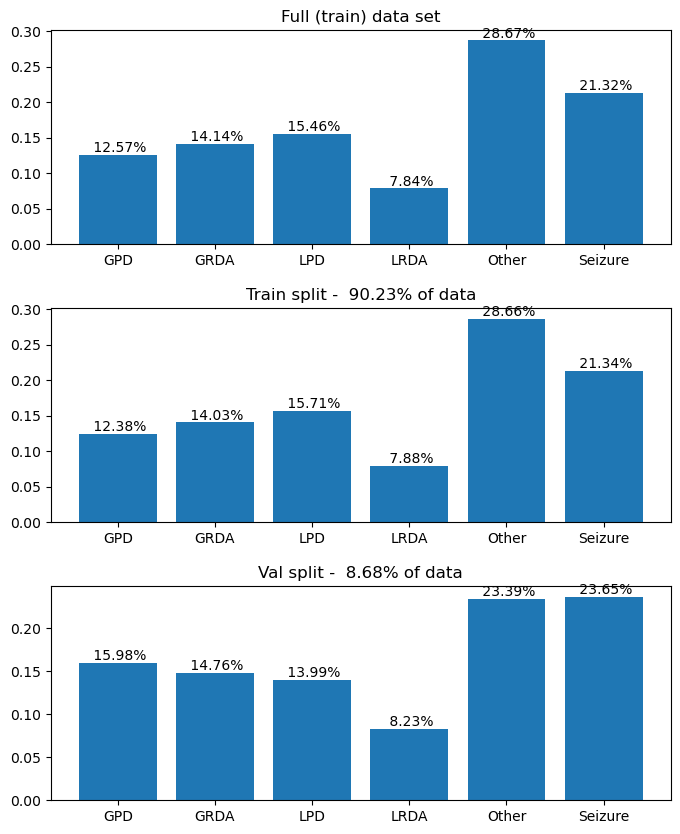

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(8,10))
fig.subplots_adjust(hspace=0.3)

axs[0].bar(X, Y1)
axs[0].set_title('Full (train) data set')

axs[1].bar(X, Y2)
axs[1].set_title(f'Train split - {(df_train.shape[0] / df.shape[0]) * 100 : .2f}% of data')

axs[2].bar(X, Y3)
axs[2].set_title(f'Val split - {(df_test.shape[0] / df.shape[0]) * 100 : .2f}% of data')

for i, p in enumerate(Y1):
    axs[0].text(i, p, f'{p*100 : .2f}%', ha='center', va='bottom')

for i, p in enumerate(Y2):
    axs[1].text(i, p, f'{p*100 : .2f}%', ha='center', va='bottom')

for i, p in enumerate(Y3):
    axs[2].text(i, p, f'{p*100 : .2f}%', ha='center', va='bottom')

plt.show()

## Evgeniya rerunning Souparna's code to do less filtering

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
df2 = pd.read_csv('train_with_nan_info.csv')
vote_cols = [c for c in df2.columns if '_vote' in c]
df2['total_votes'] = df2[vote_cols].sum(axis=1)
df2_low_total_votes = df2[df2['total_votes'] <= 2]
print('number of entries with low votes\n',df2_low_total_votes.shape[0])
df2_high = df2[df2['total_votes'] > 2]
df2_high.shape[0]

number of entries with low votes
 6676


100124

In [18]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=10)
for (t,v) in sgkf.split(X = df2_high, y=df2_high['expert_consensus'], groups=df2_high['patient_id']):
    train_idx_full = t
    test_idx_full = v
    break

In [19]:
df2_high_train = df2_high.iloc[train_idx_full]
df2_high_test = df2_high.iloc[test_idx_full]
print(df2_high_train.shape, df2_high_test.shape, df2_high.shape)
print(df2_high_train.shape[0] / df2_high.shape[0] * 100)

(89667, 20) (10457, 20) (100124, 20)
89.55595062122967


In [16]:
bpids = df2_high_test['patient_id'].values.tolist()

df2_low_total_votes = df2_low_total_votes[ ~df2_low_total_votes['patient_id'].isin(bpids) ]
print('number of entries with low votes added to the train set\n', df2_low_total_votes.shape[0])


print('making sure we dont have anything overlapping with test\n', set(df2_low_total_votes.patient_id.values).intersection(set(df2_high_test.patient_id.values)))


df2_train = pd.concat([df2_low_total_votes, df2_high_train])
df2_test = df2_high_test
df2_train.sort_index(inplace=True)

number of entries with low votes added to the train set
 6408
making sure we dont have anything overlapping with test
 set()


In [7]:
print('full dataframe\n',df2['expert_consensus'].value_counts(normalize=True), '\n')
print('train dataframe\n', df2_train['expert_consensus'].value_counts(normalize=True), '\n')
print('test dataframe\n',df2_test['expert_consensus'].value_counts(normalize=True))

full dataframe
 expert_consensus
Seizure    0.196002
GRDA       0.176601
Other      0.176105
GPD        0.156386
LRDA       0.155805
LPD        0.139101
Name: proportion, dtype: float64 

train dataframe
 expert_consensus
Seizure    0.196243
Other      0.177486
GRDA       0.177101
LRDA       0.156055
GPD        0.152839
LPD        0.140276
Name: proportion, dtype: float64 

test dataframe
 expert_consensus
Seizure    0.196615
GPD        0.192407
GRDA       0.175385
LRDA       0.156546
Other      0.151764
LPD        0.127283
Name: proportion, dtype: float64


In [8]:
df2_train.to_csv('train_final_less_filtering.csv')
df2_test.to_csv('test_final_less_filtering.csv')

In [9]:
nan_counts=['eeg_50sec_nan_row_count','eeg_10sec_nan_row_count', 'spectrogram_600sec_nan_row_count', 'spectrogram_10sec_nan_row_count' ]
df2_train[nan_counts].stack(future_stack=True).groupby(level=[1]).value_counts().unstack()

,0,1,2,3,4,5,6,7,8,9,...,4389,4397,4400,4401,4606,4701,4800,4847,4950,5197
eeg_10sec_nan_row_count,95414.0,615.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eeg_50sec_nan_row_count,92821.0,2864.0,160.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,11.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0
spectrogram_10sec_nan_row_count,95914.0,19.0,15.0,27.0,9.0,5.0,86.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spectrogram_600sec_nan_row_count,88893.0,38.0,63.0,50.0,43.0,50.0,68.0,54.0,46.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df2_train.shape[0]/df2.shape[0]

0.8995786516853933